<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/analytic_hierarchy_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**by: [João Ataíde](https://www.joaoataide.com)**
# **Métodos de Agregação e Síntese**

---



In [1]:
#importar bibliotecas
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt

# **Métodos Cardinais**

## **Analytic Hierarchy Process AHP**

In [2]:
# coding=UTF-8
import numpy as np


class AHP():

    def __init__(self, metodo, precisao, alternativas, criterios,
                 subCriterios, matrizesPreferencias):
        
        self.metodo = metodo
        self.precisao = precisao
        self.alternativas = alternativas
        self.criterios = criterios
        self.subCriterios = subCriterios
        self.matrizesPreferencias = matrizesPreferencias

        self.prioridadesGlobais = []

    @staticmethod
    def aproximado(matriz, precisao):
        soma_colunas = matriz.sum(axis=0)
        matriz_norm = np.divide(matriz, soma_colunas)
        media_linhas = matriz_norm.mean(axis=1)

        return media_linhas.round(precisao)

    @staticmethod
    def geometrico(matriz, precisao):
        media_geometrica = [np.prod(linha) ** (1 / len(linha)) for linha in matriz]
        media_geometrica_norm = media_geometrica / sum(media_geometrica)

        return media_geometrica_norm.round(precisao)

    @staticmethod
    def autovalor(matriz, precisao, interacao=100, autovetor_anterior=None):
        matriz_quadrada = np.linalg.matrix_power(matriz, 2)
        soma_linhas = np.sum(matriz_quadrada, axis=1)
        soma_coluna = np.sum(soma_linhas, axis=0)
        autovetor_atual = np.divide(soma_linhas, soma_coluna)

        if autovetor_anterior is None:
            autovetor_anterior = np.zeros(matriz.shape[0])

        diferenca = np.subtract(autovetor_atual, autovetor_anterior).round(precisao)
        if not np.any(diferenca):
            return autovetor_atual.round(precisao)

        interacao -= 1
        if interacao > 0:
            return AHP.autovalor(matriz_quadrada, precisao, interacao, autovetor_atual)
        else:
            return autovetor_atual.round(precisao)

    @staticmethod
    def consistencia(matriz):
        if matriz.shape[0] and matriz.shape[1] > 2:
            # Teorema de Perron-Frobenius
            lambda_max = np.real(np.linalg.eigvals(matriz).max())
            ic = (lambda_max - len(matriz)) / (len(matriz) - 1)
            ri = {3: 0.52, 4: 0.89, 5: 1.11, 6: 1.25, 7: 1.35, 8: 1.40, 9: 1.45,
                  10: 1.49, 11: 1.52, 12: 1.54, 13: 1.56, 14: 1.58, 15: 1.59}
            rc = ic / ri[len(matriz)]
        else:
            lambda_max = 0
            ic = 0
            rc = 0

        return lambda_max, ic, rc

    def VetorPrioridadesLocais(self):
        vetor_prioridades_locais = {}
        for criterio in self.matrizesPreferencias:
            matriz = np.array(self.matrizesPreferencias[criterio])
            if self.metodo == 'aproximado':
                prioridades_locais = self.aproximado(matriz, self.precisao)
            elif self.metodo == 'geometrico':
                prioridades_locais = self.geometrico(matriz, self.precisao)
            else:
                if matriz.shape[0] and matriz.shape[1] >= 2:
                    prioridades_locais = self.autovalor(matriz, self.precisao)
                else:
                    prioridades_locais = self.aproximado(matriz, self.precisao)

            vetor_prioridades_locais[criterio] = prioridades_locais

            lambda_max, ic, rc = self.consistencia(matriz)

        return vetor_prioridades_locais

    def VetorPrioridadesGlobais(self, prioridades, pesos, criterios):
        for criterio in criterios:
            peso = pesos[criterios.index(criterio)]
            prioridades_locais = prioridades[criterio]
            prioridade_global = np.round(peso * prioridades_locais, self.precisao)

            if criterio in self.subCriterios:
                self.VetorPrioridadesGlobais(prioridades, prioridade_global, self.subCriterios[criterio])
            else:
                self.prioridadesGlobais.append(prioridade_global)

    def Resultado(self):
        prioridades = self.VetorPrioridadesLocais()
        self.VetorPrioridadesGlobais(prioridades, prioridades['criterios'], self.criterios)
        prioridades = np.array(self.prioridadesGlobais)
        prioridades = prioridades.sum(axis=0).round(self.precisao)

        return dict(zip(self.alternativas, prioridades))


### **Método aproximado**

In [3]:
matriz = np.array([[1, 6, 3],
                   [1/6, 1, 1/2],
                   [1/3, 2, 1]])

precisao = 2
AHP.aproximado(matriz, precisao)

array([0.67, 0.11, 0.22])

### **Método geométrico**

In [4]:
matriz = np.array([[1, 6, 3],
                   [1/6, 1, 1/2],
                   [1/3, 2, 1]])

precisao = 2
AHP.geometrico(matriz, precisao)

array([0.67, 0.11, 0.22])

### **Método Autovalor**

In [5]:
matriz = np.array([[1, 6, 3],
                   [1/6, 1, 1/2],
                   [1/3, 2, 1]])

precisao = 2
AHP.autovalor(matriz, precisao, interacao=100)

array([0.67, 0.11, 0.22])

### **Calculos Consistência**

In [6]:
matriz = np.array([[1, 6, 3],
                   [1/6, 1, 1/2],
                   [1/3, 2, 1]])


AHP.consistencia(matriz)

(3.0, 0.0, 0.0)

Se RC < 10% é consistente.

### **Exemplo do Lider**

In [7]:
lider = AHP(
    metodo='',
    precisao=3,
    alternativas=['Tom', 'Dick', 'Harry'],
    criterios=['Experiência', 'Educação', 'Carisma', 'Idade'],
    subCriterios={},
    matrizesPreferencias={
        'Experiência': [
            [1, 1 / 4, 4],
            [4, 1, 9],
            [1 / 4, 1 / 9, 1]
        ],
        'Educação': [
            [1, 3, 1 / 5],
            [1 / 3, 1, 1 / 7],
            [5, 7, 1]
        ],
        'Carisma': [
            [1, 5, 9],
            [1 / 5, 1, 4],
            [1 / 9, 1 / 4, 1]
        ],
        'Idade': [
            [1, 1 / 3, 5],
            [3, 1, 9],
            [1 / 5, 1 / 9, 1]
        ],
        'criterios': [
            [1, 4, 3, 7],
            [1 / 4, 1, 1 / 3, 3],
            [1 / 3, 3, 1, 5],
            [1 / 7, 1 / 3, 1 / 5, 1]
        ]
    })

In [14]:
lider.VetorPrioridadesLocais()

{'Carisma': array([0.743, 0.194, 0.063]),
 'Educação': array([0.188, 0.081, 0.731]),
 'Experiência': array([0.217, 0.717, 0.066]),
 'Idade': array([0.265, 0.672, 0.063]),
 'criterios': array([0.548, 0.127, 0.27 , 0.056])}

In [9]:
resultado = lider.Resultado()
resultado

{'Dick': 0.493, 'Harry': 0.15, 'Tom': 0.359}

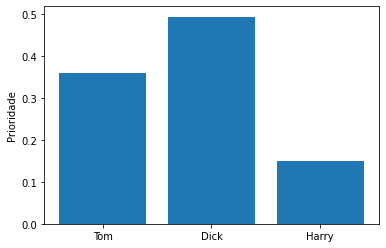

In [10]:
plt.bar(resultado.keys(), resultado.values())
plt.ylabel('Prioridade')
plt.show()